## MINST dataset training and validation example on ConvNet

In [1]:
'''Trains a simple ConvNet on the MNIST dataset. It gets over 99.60% test accuracy after 48 epochs
(but there is still a margin for hyperparameter tuning). Training can take an hour or so!'''

# Import libraries
from __future__ import print_function
import numpy as np
import math
from math import ceil
import tensorflow as tf
import os   
import seaborn as sns
import matplotlib.pyplot as plt  # library for plotting math functions
import pandas as pd
import keras   # Import keras framework with various functions, models and structures
from keras.datasets import mnist # gets MNIST dataset from repository
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

# Set parameters for plots
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

print ("TensorFlow version: " + tf.__version__)

Using TensorFlow backend.


TensorFlow version: 2.1.0


In [2]:
LABELS= ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Define the confusion matrix for the results
def show_confusion_matrix(validations, predictions, num_classes):
    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(num_classes, num_classes))
    hm = sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.yticks(rotation = 0)  # Don't rotate (vertically) the y-axis labels
    hm.invert_yaxis() # Invert the labels of the y-axis
    hm.set_ylim(0, len(matrix))
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [13]:
# Define hyperparameters
batch_size = 512   # size of mini-baches
num_classes = 10   # number of classes/digits: 0, 1, 2, ..., 9
epochs = 50        # how many times all traing examples will be used to train the model

# Input image dimensions
img_rows, img_cols = 28, 28

# Split the data between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data() # 60000 training and 10000 testing examples

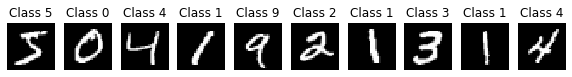

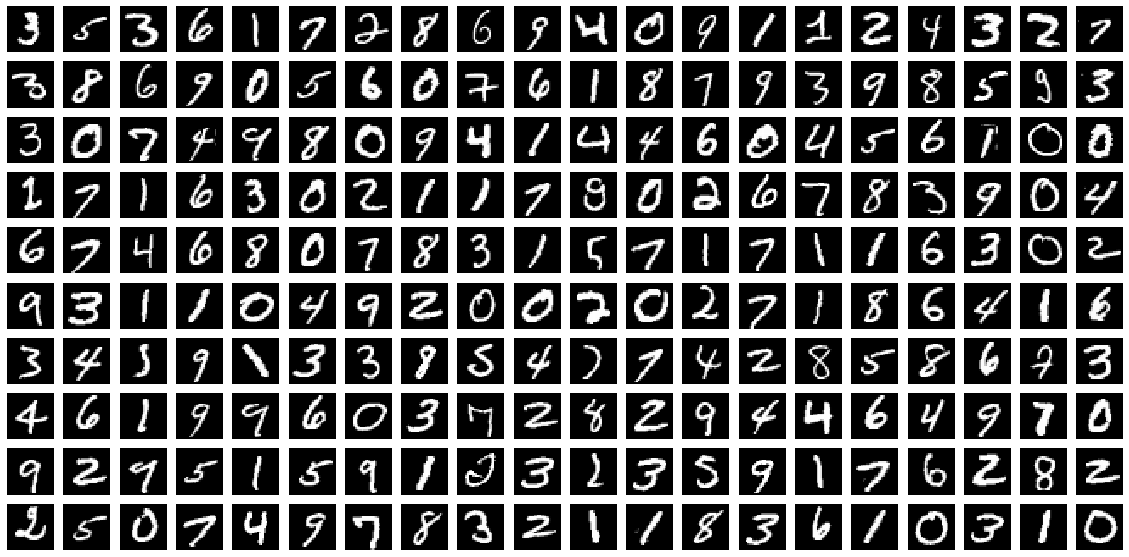

In [7]:
# Show a few sample digits from the training set
plt.rcParams['figure.figsize'] = (2.5, 2.5) # set default size of plots
col1 = 10
row1 = 1
fig = plt.figure(figsize=(col1, row1))
for index in range(0, col1*row1):
    fig.add_subplot(row1, col1, index + 1)
    plt.axis('off')
    plt.imshow(x_train[index]) # index of the sample picture
    plt.title("Class " + str(y_train[index]))
plt.show()

# Show a few sample digits from the training set
plt.rcParams['figure.figsize'] = (1.0, 1.0) # set default size of plots
col2 = 20
row2 = 10
fig = plt.figure(figsize=(col2, row2))
for index in range(col1*row1, col1*row1 + col2*row2):
    fig.add_subplot(row2, col2, index - col1*row1 + 1)
    plt.axis('off')
    plt.imshow(x_train[index]) # index of the sample picture
plt.show()

In [9]:
# According to the different formats reshape training and testing data
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
# Transform training and testing data and show their shapes
x_train = x_train.astype('float32')   # Copy this array and cast it to a specified type
x_test = x_test.astype('float32')     # Copy this array and cast it to a specified type
x_train /= 255   # Transfrom the training data from the range of 0 and 255 to the range of 0 and 1
x_test /= 255    # Transfrom the testing data from the range of 0 and 255 to the range of 0 and 1
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors (integers) to binary class matrices using as specific 
y_train = keras.utils.to_categorical(y_train, num_classes) # y_train - a converted class vector into a matrix (integers from 0 to num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes) # y_test - a converted class vector into a matrix (integers from 0 to num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [12]:
y_test.shape

(10000, 10)

## Create the network structure

In [6]:
# Define the sequential Keras model composed of a few layers
model = Sequential()   # establishes the type of the network model
# Conv2D - creates a convolutional layer (https://keras.io/layers/convolutional/#conv2d) with 
# filters - specified number of convolutional filters
# kernel_size - defines the frame (sliding window) size where the convolutional filter is implemented
# activation - sets the activation function for this layers, here ReLU
# input_shape - defines the shape of the input matrix (vector), here input_shape = (1, img_rows, img_cols)
model.add(Conv2D(filters=32, kernel_size=(3, 3),activation='relu', input_shape=input_shape))
# model.add(Conv2D(32, (3, 3), activation='relu')) - shoter way of the above code
# MaxPooling2D pools the max value from the frame (sliding window) of 2 x 2 size
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.20)) # Implements the drop out with the probability of 0.20
model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128,(3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.30))
model.add(Conv2D(256,(3, 3), activation='relu',padding='same'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.40))
model.add(Conv2D(512,(3, 3), activation='relu',padding='same'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.50))
# Finish the convolutional model and flatten the layer which does not affect the batch size.
model.add(Flatten())
# Use a dense layer (MLP) consisting of 256 neurons with relu activation functions
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

## Compile and train the network

In [7]:
# Compile the model using optimizer
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),  # choose the optimizer
              metrics=['acc']) # List of metrics to be evaluated by the model during training and testing: https://keras.io/models/model/#compile

# Learning rate reduction durint the training process: https://keras.io/callbacks/#reducelronplateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', # quantity to be monitored (val_loss)
                                            factor=0.5, # factor by which the learning rate will be reduced. new_lr = lr * factor
                                            patience=5, # number of epochs that produced the monitored quantity with no improvement after which training will be stopped
                                            verbose=1,  # 0: quiet, 1: update messages.
                                            min_lr=0.001) # lower bound on the learning rate

# Augmentation of training data. It generates batches of tensor image data with real-time data augmentation. The data will be looped over in batches.
datagen = ImageDataGenerator(
        rotation_range=5, # rotate images in degrees up to the given degrees
        zoom_range=0.2, # zoom images
        width_shift_range=0.15,  # shift images horizontally
        height_shift_range=0.15)  # shift images vertically
# Computes the internal data stats related to the data-dependent transformations, based on an array of samples x_train
datagen.fit(x_train) # Fits the data generator to the sample data x_train.

# Simple train the model, validate, evaluate, and present scores
'''history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,  # no of training epochs
          verbose=1,  # 0 = silent, 1 = progress bar, 2 = one line per epoch
          validation_data=(x_test, y_test),
          validation_split=0.2,  # cross-validation split 1/5
          shuffle=True) # method of how to shuffle training and validation data '''

# Advanced train the model, validate, evaluate, and present scores: https://keras.io/models/model/#fit_generator
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                            epochs=epochs,  # no of training epochs
                            steps_per_epoch=x_train.shape[0]//batch_size, # no of mini-batches
                            validation_data=(x_test, y_test),
                            verbose=1,  # 0 = silent, 1 = progress bar, 2 = one line per epoch
                            callbacks=[learning_rate_reduction])

Epoch 1/50
117/117 [==============================] - 271s 2s/step - loss: 1.9644 - acc: 0.2841 - val_loss: 0.8554 - val_acc: 0.6723
Epoch 2/50
117/117 [==============================] - 270s 2s/step - loss: 0.8482 - acc: 0.7236 - val_loss: 0.1902 - val_acc: 0.9377
Epoch 3/50
117/117 [==============================] - 391s 3s/step - loss: 0.3834 - acc: 0.8843 - val_loss: 0.0880 - val_acc: 0.9706
Epoch 4/50
117/117 [==============================] - 691s 6s/step - loss: 0.2535 - acc: 0.9239 - val_loss: 0.0543 - val_acc: 0.9819
Epoch 5/50
117/117 [==============================] - 18621s 159s/step - loss: 0.1949 - acc: 0.9425 - val_loss: 0.1020 - val_acc: 0.9688
Epoch 6/50
117/117 [==============================] - 351s 3s/step - loss: 0.1652 - acc: 0.9514 - val_loss: 0.0342 - val_acc: 0.9883
Epoch 7/50
117/117 [==============================] - 361s 3s/step - loss: 0.1467 - acc: 0.9578 - val_loss: 0.0307 - val_acc: 0.9899
Epoch 8/50
117/117 [==============================] - 371s 3s/ste

## Evaluate, score and plot the accuracy and the loss

Test loss: 0.011101936267607016
Test accuracy: 0.9962999820709229


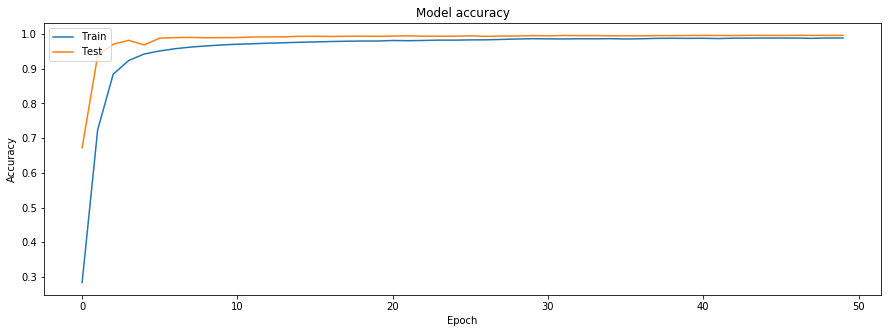

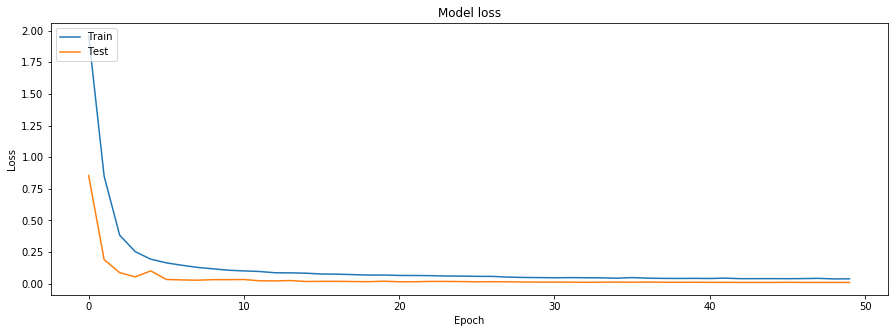

In [8]:
# Evaluate the model and print out the final scores for the test set
score = model.evaluate(x_test, y_test, verbose=0)  # evaluate the model on the test set
print('Test loss:', score[0])      # print out the loss = score[0] (generalization error) 
print('Test accuracy:', score[1])  # print out the generalization accuracy = score[1] of the model on test set

# Plot training & validation accuracy values: https://keras.io/visualization/#training-history-visualization
plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots
plt.plot(history.history['acc']) # The history object gets returned by the fit method of models.
plt.plot(history.history['val_acc'])  # val_accuracy
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')  # OR plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values: https://keras.io/visualization/#training-history-visualizatio
plt.plot(history.history['loss']) # The history object gets returned by the fit method of models.
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc ='upper left')  # OR plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

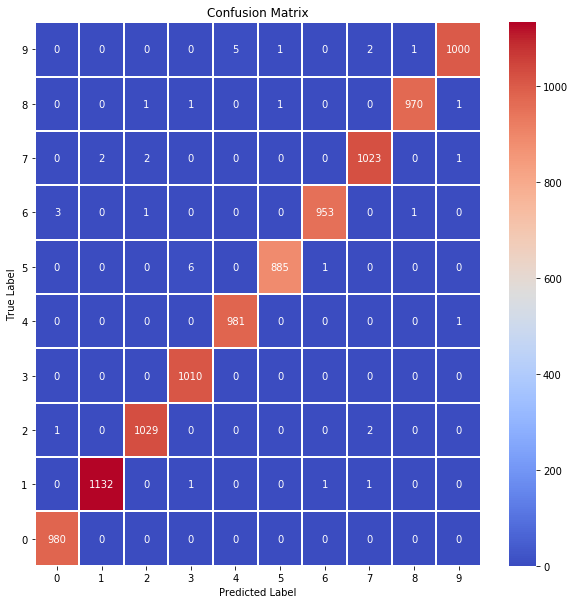

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       0.99      1.00      1.00      1010
           4       0.99      1.00      1.00       982
           5       1.00      0.99      0.99       892
           6       1.00      0.99      1.00       958
           7       1.00      1.00      1.00      1028
           8       1.00      1.00      1.00       974
           9       1.00      0.99      0.99      1009

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



In [9]:
# Use the trained model for predictions of the test data
y_pred_test = model.predict(x_test)

# Take the class with the highest probability from the test predictions as a winning one
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

# Show the confution matrix of the collected results
show_confusion_matrix(max_y_test, max_y_pred_test, num_classes)

# Print classification report
print(classification_report(max_y_test, max_y_pred_test))

Number of misclassified examples:  37
Misclassified examples:
[ 359  445  582  659  674  716  947 1039 1232 1393 1737 1878 1901 2035
 2130 2182 2414 2462 2597 2939 3225 3422 3762 4176 4620 4761 5654 5937
 6558 6571 6576 8316 8376 8408 9530 9642 9729]
Misclassified images (original class : predicted class):


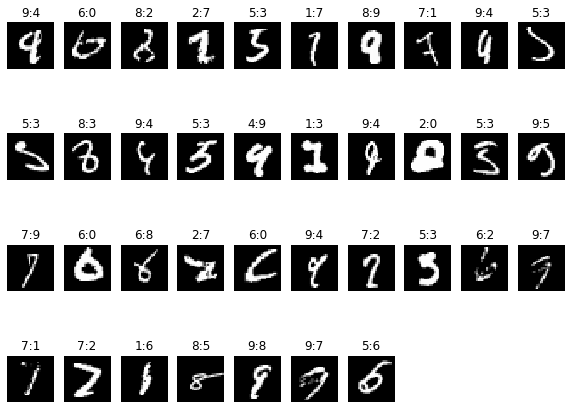

In [10]:
# Find out misclassified examples
classcheck = max_y_test - max_y_pred_test  # 0 - when the class is the same, 1 - otherwise
misclassified = np.where(classcheck != 0)[0]
num_misclassified = len(misclassified)

# Print misclassification report
print('Number of misclassified examples: ', str(num_misclassified))
print('Misclassified examples:')
print(misclassified)

# Show misclassified examples:
print('Misclassified images (original class : predicted class):')
plt.rcParams['figure.figsize'] = (2.5, 2.5) # set default size of plots
col = 10
row = 2 * math.ceil(num_misclassified / col)
fig = plt.figure(figsize=(col, row))
for index in range(0,num_misclassified):
    fig.add_subplot(row, col, index + 1 + col*(index//col))
    plt.axis('off')
    plt.imshow(x_test[misclassified[index]].reshape(img_rows, img_cols)) # index of the test sample picture
    plt.title(str(max_y_test[misclassified[index]]) + ":" + str(max_y_pred_test[misclassified[index]]))
plt.show()